En este notebook vamos a calcular la función radial.

In [1]:
#Importamos paquetes.
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import scipy.integrate as integrate

#Para el tamaño de las gráficas.
params = {'xtick.labelsize': 30, 'ytick.labelsize': 20, 'font.size': 30}
mpl.rcParams.update(params)

#Definimos el valor de las constantes (en MeV o adimensionales).
F_pi_val = 108 # o 104.8 o 186
e_val = 4.648 # o 4.84
m_pi = 138
alpha = 0.0444
m_rho = 796
kapp_inv = 0.1886
#Factores de conversión de unidades de longitud o energía.
Factor_l = (2/(e_val *F_pi_val))
Factor_e = F_pi_val/(4*e_val)* (12*np.pi**2)

n_r = 100 #5000 #Numero de distancias radiales que vamos a tomar en las integrales.
r_f = 10. #30 #Distancia maxima que camos a tomar en las integrales (En unidades de Skyrme)
rs = np.linspace(1e-6, r_f, n_r)* Factor_l#Array redimensionado a MeV^-1

lam = 53.4570253 / (4*6.336630541) * Factor_l**2#Lambda^2 en el cual vamos a centrar la busqueda.

Definimos nuestra función aproximada.

In [ ]:
@njit
def f(r, lam): return np.pi - np.pi / np.sqrt( 1. + lam / (r*r) )

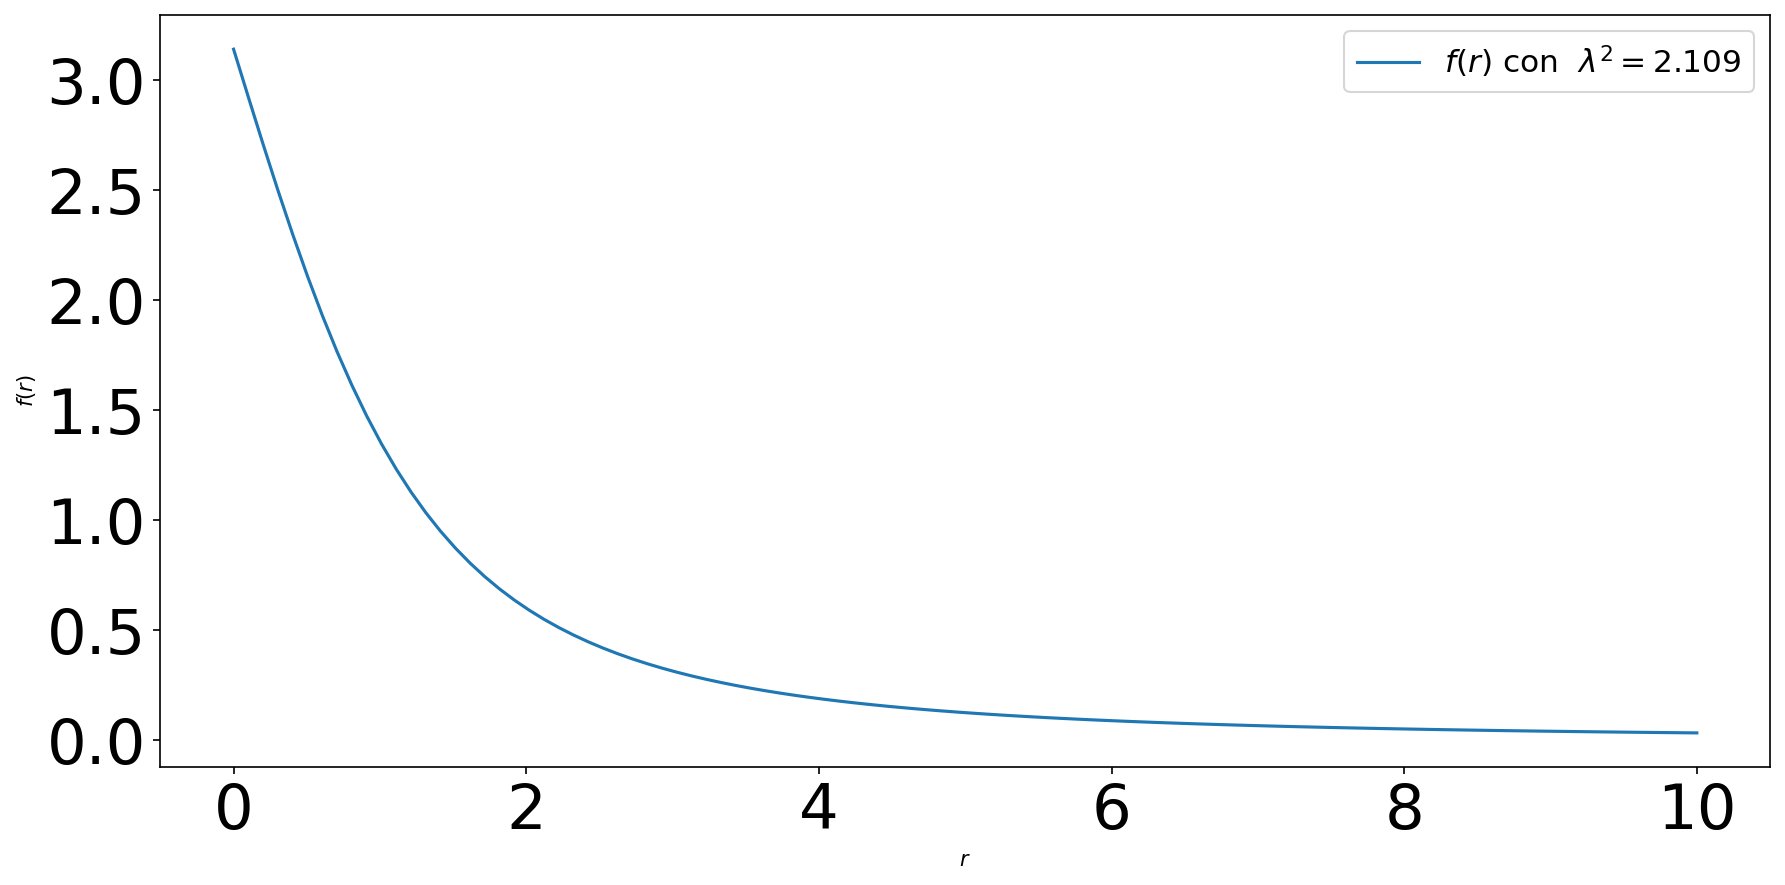

In [ ]:
plt.figure('ki frente a r', figsize=(12, 6), dpi = 150)
plt.plot(rs / Factor_l, f(rs, lam), '-', label=r'$f(r)$ con  $\lambda^2=${}'.format(round(lam/Factor_l**2, 3)))
plt.xlabel(r'$r$'); plt.ylabel(r'$f(r)$')
plt.legend(loc='upper right', fontsize = 15)
plt.yticks(fontsize=30)
plt.tight_layout()
plt.show()

Finished at i =  51


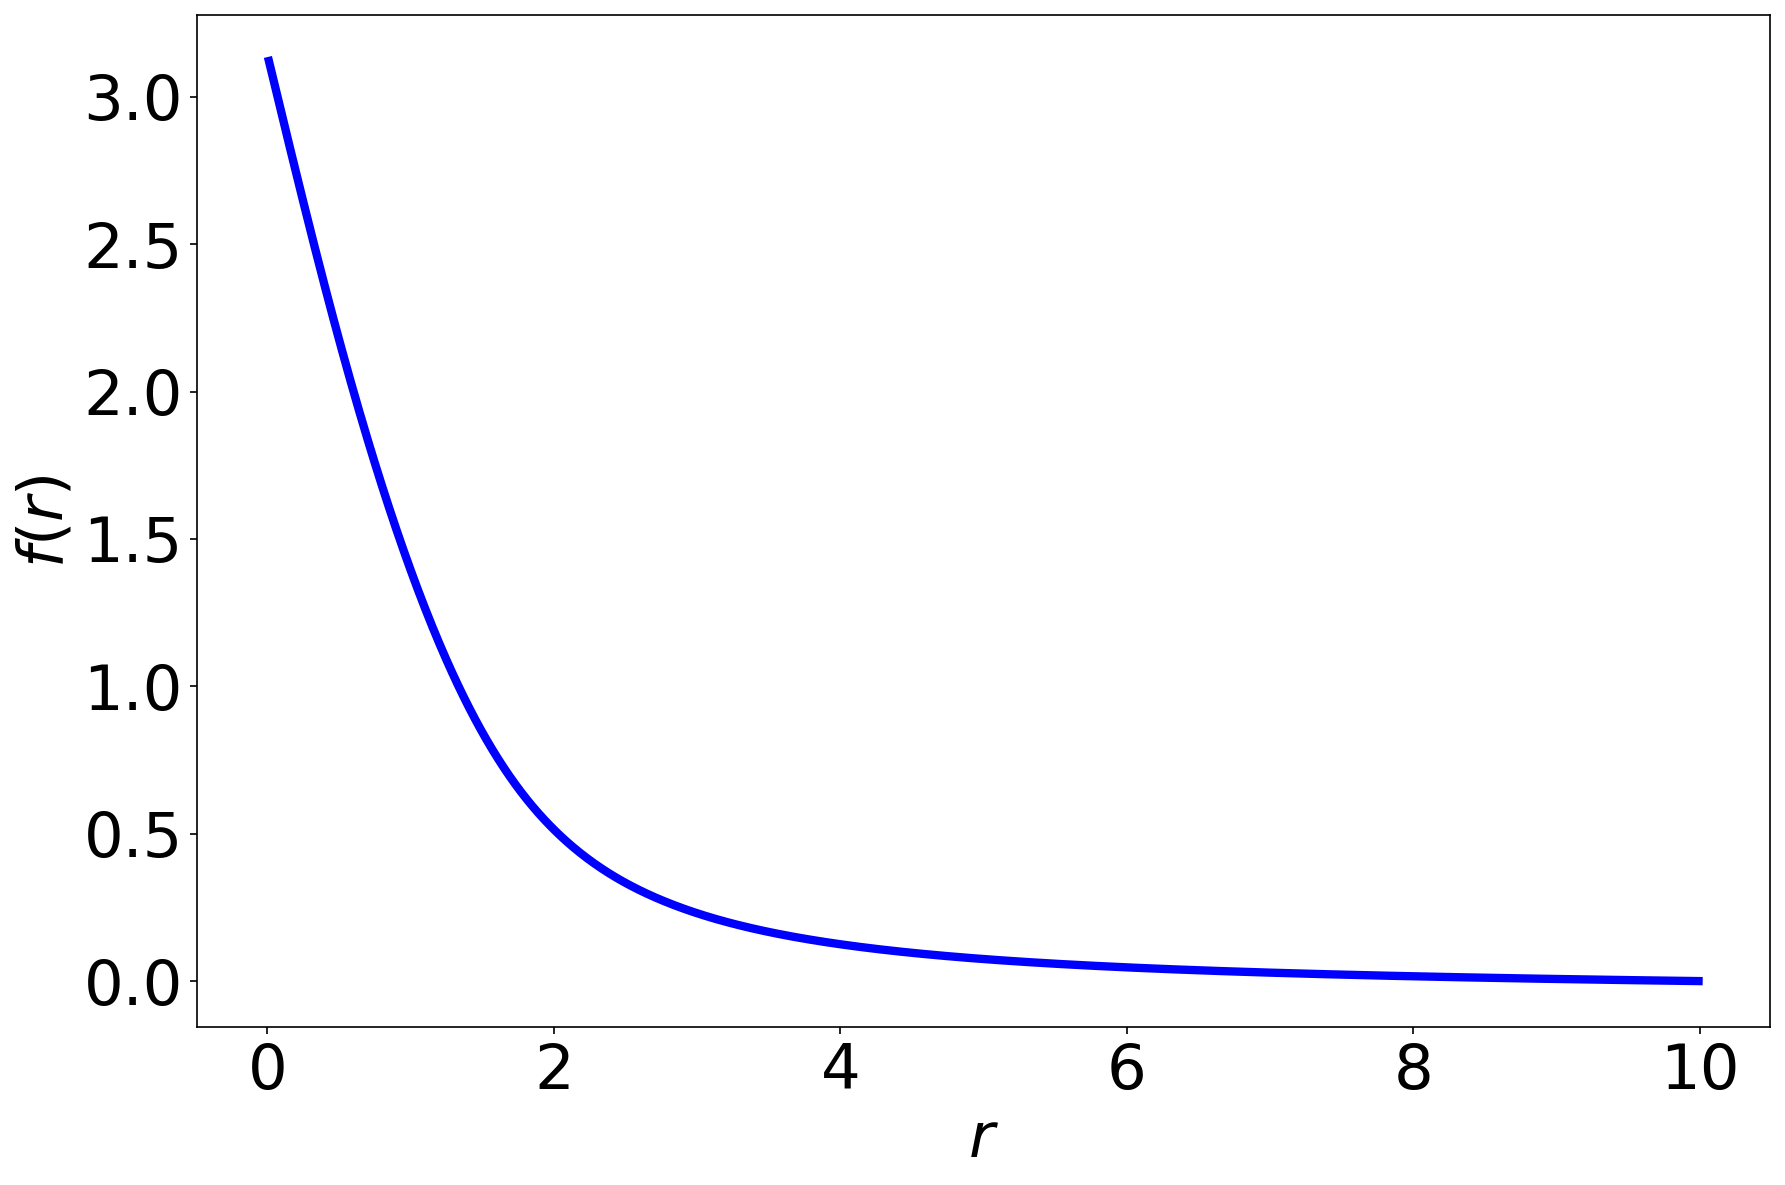

In [ ]:
# Parameters
c2 = 1.0
c4 = 1.0
c6 = 0.0 # 2*lambda2*fpi**2*e**4/hbarc**3
c0 = 0.0 # 2*mpi**2/(fpi*e)**2

coefs = [c2, c4, c6, c0]

#------------------------------------------------------------------------------

# Energy density
def ED(r, f, df, coefs):
    if r == 0:
        ED_2 = coefs[0]*(df**2 + 2)
        ED_4 = coefs[1]*(8*df**2 + 4)
        ED_6 = coefs[2]*df**2
        ED_0 = coefs[3]*2
    else:
        ED_2 = coefs[0]*(df**2 + 2*np.sin(f)**2/r**2)
        ED_4 = coefs[1]*(8*(np.sin(f)*df/r)**2 + 4*(np.sin(f)/r)**4)
        ED_6 = coefs[2]*(np.sin(f)**2*df/r**2)**2
        ED_0 = coefs[3]*(1 - np.cos(f))
    return (ED_2 + ED_4 + ED_6 + ED_0)/(24*np.pi**2)

# Equations of motion
def EL(r, inits):
    f, fp = inits
    
    df = fp
    ddf = (c2*(-2*r**3*df + r**2*np.sin(2*f)) + 
           c4*(-r**2*np.sin(2*f)*df**2 + np.sin(f)**2*np.sin(2*f)) + 
           c6*(-df**2*np.sin(f)**2*np.sin(2*f) + 2*np.sin(f)**4/r*df) + 
           c0/2*r**4*np.sin(f))/(c2*r**4 + 2*c4*r**2*np.sin(f)**2 + 
                                 c6*np.sin(f)**4)

    if ddf > 5:
        ddf = 5
    if ddf < -5:
        ddf = -5
    
    return np.array([df, ddf])

#------------------------------------------------------------------------------

# Initial conditions
r_init = 0.01
r_end = 10.0
r = np.arange(r_init, r_end, 0.01)
N = len(r)

f0 = np.pi
f_tol = 1e-11

# Shooting method
param_max = 10.0
param_min = -8.0
iterations = 60
for i in range(iterations):
    param = (param_max + param_min)/2
    
    vinic = [f0 + param*r_init, param]
    sol = integrate.solve_ivp(EL, (r_init, r_end), vinic, method = 'RK45', t_eval = r)
    ff, df = sol.y[0], sol.y[1]
    
    if abs(ff[-1]) < f_tol:
        print('Finished at i = ', i)
        break
    
    if ff[-1] > 0:
        param_max = param
    else:
        param_min = param

ddf = np.zeros(N)
for i in range(N):
    ddf[i] = EL(r[i], [ff[i], df[i]])[1]

plt.figure('ki frente a r', figsize=(12, 8), dpi = 150)
plt.plot(r, ff, '-b', label='Solución exacta', linewidth = 4)
plt.xlabel(r'$r$', fontsize=30); plt.ylabel(r'$f(r)$', fontsize=30)
plt.yticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tight_layout()
plt.show()

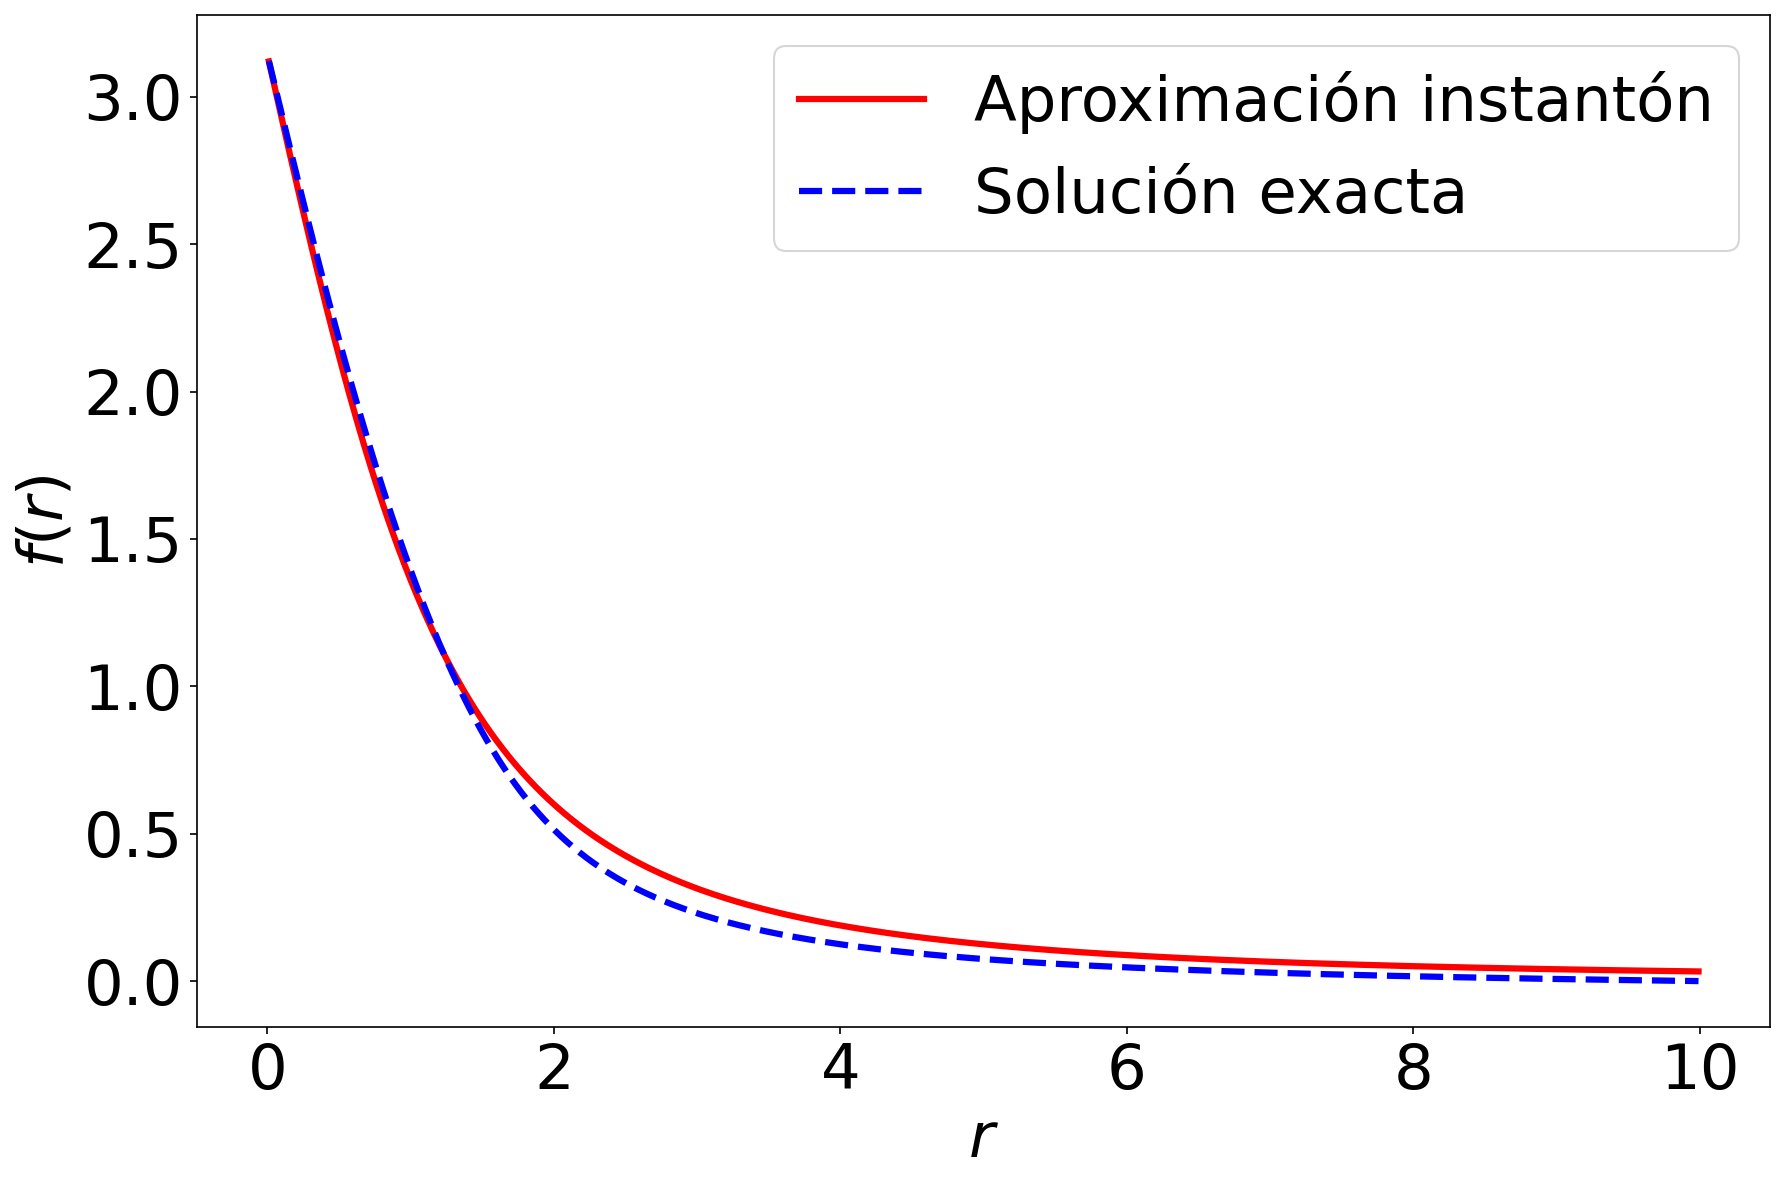

In [ ]:
plt.figure('ki frente a r', figsize=(12, 8), dpi = 150)
plt.plot(r, f(r* Factor_l, lam), '-r', label='Aproximación instantón', linewidth = 3)
plt.plot(r, ff, '--b', label='Solución exacta', linewidth = 3)
plt.xlabel(r'$r$', fontsize=30); plt.ylabel(r'$f(r)$', fontsize=30)
plt.yticks(fontsize=30)
plt.legend(loc='upper right', fontsize=30)
plt.tight_layout()
plt.show()